In [1]:
import pandas as pd
import os, shutil
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


In [2]:
# import zipfile
# z = zipfile.ZipFile('braintumords.zip')
# z.extractall()

In [3]:
# folder = 'brain_tumor_dataset/yes/'
# count = 1

# for filename in os.listdir(folder):
#     source = folder + filename
#     destination = folder + "Y_" +str(count)+".jpg"
#     os.rename(source, destination)
#     count+=1
# print("All files are renamed in the yes dir.")

In [4]:
# folder = 'brain_tumor_dataset/no/'
# count = 1

# for filename in os.listdir(folder):
#     source = folder + filename
#     destination = folder + "N_" + str(count)+ ".jpg"
#     os.rename(source, destination)
#     count += 1
# print("All files are renamed in the yes dir.")

In [5]:
listyes = os.listdir('brain_tumor_dataset/yes/')
num_images_with_tumor = len(listyes)
listno = os.listdir('brain_tumor_dataset/no/')
num_images_without_tumor = len(listno)
print(num_images_with_tumor)
print(num_images_without_tumor)

155
99


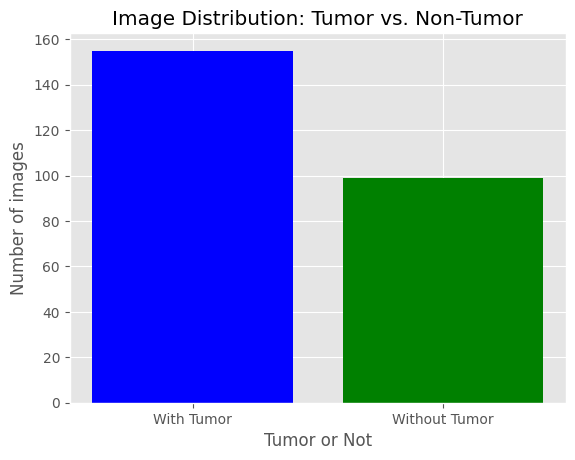

In [6]:
data = {'With Tumor': num_images_with_tumor, 'Without Tumor': num_images_without_tumor}
categories = list(data.keys())
values = list(data.values())
plt.bar(categories, values, color=['blue', 'green'])
plt.xlabel('Tumor or Not')
plt.ylabel('Number of images')
plt.title('Image Distribution: Tumor vs. Non-Tumor')
plt.show()

In [7]:
# Data Augmentation
# Total number of images = 155+98
# 155+98 = 253
(155/253)*100,(98/253)*100, #so it is imbalanced

(61.26482213438735, 38.73517786561265)

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2

In [32]:

import cv2
import time


def augmented_data(file_dir, n_generated_samples, save_to_dir):
    train_datagen = ImageDataGenerator(
        rotation_range=10, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    for filename in os.listdir(file_dir):
        img_path = os.path.join(file_dir, filename)

        # Check if the file is an image (you can add more extensions if needed)
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            print(f"Skipping non-image file: {filename}")
            continue
        
        image = cv2.imread(img_path)

        if image is None:
            print(f"Warning: Unable to read image {img_path}. Skipping.")
            continue

        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        
        for batch in train_datagen.flow(
            x=image,
            batch_size=1,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format='jpg'
        ):
            i += 1
            if i >= n_generated_samples:
                break

yes_path = 'brain_tumor_dataset/yes'
no_path = 'brain_tumor_dataset/no'
augmented_data_path = 'augmented_data/'

# Create augmented_data directory if it doesn't exist
os.makedirs(augmented_data_path + 'yes', exist_ok=True)
os.makedirs(augmented_data_path + 'no', exist_ok=True)

start_time = time.time()
augmented_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path + 'yes')
augmented_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path + 'no')
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


Skipping non-image file: .ipynb_checkpoints
Execution time: 90.69 seconds


In [33]:
def describe_data(main_path):
    yes_path = "augmented_data/yes/" 
    no_path = "augmented_data/no/"
    number_of_yes = len(os.listdir(yes_path))
    number_of_no = len(os.listdir(no_path))
    total = (number_of_yes + number_of_no)
    yes_per = (number_of_yes/total)*100
    no_per = (number_of_no/total)*100
    print(f"Total samples {total}")
    print(f"Total percentage of augmented yes {yes_per}")
    print(f"Total percentage of augmented no {no_per}")
    
    

In [34]:
describe_data(augmented_data_path)

Total samples 1812
Total percentage of augmented yes 51.324503311258276
Total percentage of augmented no 48.675496688741724


In [35]:
listyes = os.listdir('augmented_data/yes/')
num_images_with_tumor = len(listyes)
listno = os.listdir('augmented_data/no/')
num_images_without_tumor = len(listno)
print(num_images_with_tumor)
print(num_images_without_tumor)


930
882


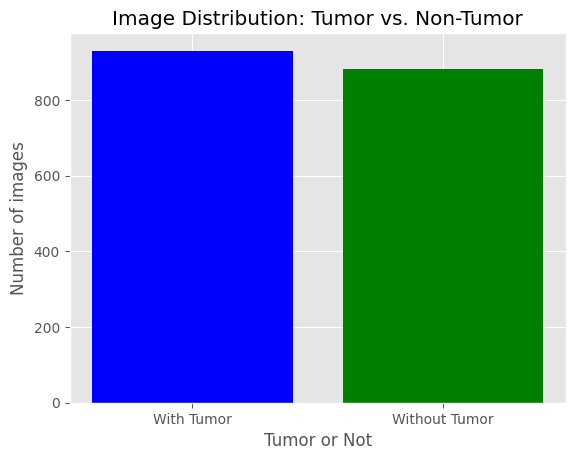

In [36]:
data = {'With Tumor': num_images_with_tumor, 'Without Tumor': num_images_without_tumor}
categories = list(data.keys())
values = list(data.values())
plt.bar(categories, values, color=['blue', 'green'])
plt.xlabel('Tumor or Not')
plt.ylabel('Number of images')
plt.title('Image Distribution: Tumor vs. Non-Tumor')
plt.show()

In [ ]:
# DATA PREPROCESSING
# Convert BGR TO GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [3]:
import imutils
def crop_brain_tumor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.threshold(blur, 45, 255, cv2.THRESH_BINARY)[1]
    erode =cv2.erode(thresh, None, iterations = 2)
    dilate = cv2.dilate(erode, None, iterations = 2)
    cnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    return new_image
    

In [4]:
import cv2
import time
img = cv2.imread('augmented_data/yes/aug_Y_1_0_1362.jpg')
crop_brain_tumor(img)

array([[[ 6,  6,  6],
        [ 6,  6,  6],
        [ 3,  3,  3],
        ...,
        [ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 5,  5,  5],
        [ 5,  5,  5],
        [ 3,  3,  3],
        ...,
        [ 4,  4,  4],
        [ 4,  4,  4],
        [ 4,  4,  4]],

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 4,  4,  4],
        [ 3,  3,  3],
        [ 3,  3,  3]],

       ...,

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 8,  8,  8],
        ...,
        [ 5,  5,  5],
        [ 4,  4,  4],
        [ 3,  3,  3]],

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [13, 13, 13],
        ...,
        [ 5,  5,  5],
        [ 4,  4,  4],
        [ 3,  3,  3]],

       [[ 5,  5,  5],
        [ 5,  5,  5],
        [ 3,  3,  3],
        ...,
        [ 5,  5,  5],
        [ 4,  4,  4],
        [ 3,  3,  3]]], dtype=uint8)

In [5]:
# resizing and shuffling the data
from sklearn.utils import shuffle
def load_data(dir_list, img_size):
    X=[]
    y=[]
    img_width,img_height = img_size
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + "/" + filename)
            image = crop_brain_tumor(image)
            image = cv2.resize(image, dsize=(img_width, img_height),interpolation = cv2.INTER_CUBIC)
            image = image/255.0
            X.append(image)
            # if tumorous -> 1 if non-tumorous -> 0
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X= np.array(X)
    y= np.array(y)
    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [6]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

image_width, image_height = (240,240)

X,y = load_data([augmeneted_yes,augmeneted_no],(image_width, image_height))

Number of example is : 1812
X SHAPE is : (1812, 240, 240, 3)
y SHAPE is : (1812,)


In [ ]:
 # Train test Split Validate

Failed to load image. Please check the file path.


In [12]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir, "test")
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir, "train")
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir, "valid")
    os.mkdir(valid_dir)

In [13]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir,'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir,'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir,'tumorous')
    os.mkdir(infected_valid_dir)
    
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir,'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir,'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir,'nontumorous')
    os.mkdir(healthy_valid_dir)


NameError: name 'valid_dir' is not defined

In [19]:
# 930 + 882 = 1812
# 930 -> yes, 882->no
# 0.8 *930 = 744 , 0.8*882 = 706
# getting the 10%
# 930-744= 186
# 186/2 = 93
# 0.1*930 = 93
# 744 + 93 = 837
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')
infected_valid_dir = os.path.join('tumorous_and_nontumorous/valid','tumorous')
infected_train_dir =os.path.join('tumorous_and_nontumorous/train','tumorous')
infected_test_dir =os.path.join('tumorous_and_nontumorous/test','tumorous')
healthy_train_dir = os.path.join('tumorous_and_nontumorous/train','nontumorous')
healthy_test_dir = os.path.join('tumorous_and_nontumorous/test','nontumorous')
healthy_valid_dir =os.path.join('tumorous_and_nontumorous/valid','nontumorous')

In [16]:
files = os.listdir('augmented_data/yes')
fnames =[]
for i in range(0,744):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst =  os.path.join(infected_train_dir, fname)
    shutil.copyfile(src,dst)

In [17]:
files = os.listdir('augmented_data/yes/')
fnames =[]
for i in range(744,837):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst =  os.path.join(infected_test_dir, fname)
    shutil.copyfile(src,dst)

In [18]:
files = os.listdir('augmented_data/yes/')
fnames =[]
for i in range(837,930):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst =  os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src,dst)

In [24]:
# DIVIDING THE NON TUMOROUS DATA
# 882 non-tumourous
# 0.8 * 882 = 706, 
# 0.1*882 =88
# 706+88 =794

794

In [25]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,706):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [26]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(706,794):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [27]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(794,882):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
# MODEL BUILDING

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    vertical_flip =0.4,
    rotation_range =40,
    shear_range =0.2,
    width_shift_range =0.4,
    height_shift_range =0.4,
    fill_mode ='nearest'
)
test_data_gen =ImageDataGenerator(rescale=1/255)
valid_data_gen =ImageDataGenerator(rescale=1/255)


In [5]:
train_generator = train_datagen.flow_from_directory(
    'tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240),
    class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 1450 images belonging to 2 classes.


In [6]:
test_generator = train_datagen.flow_from_directory(
    'tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240),
    class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 181 images belonging to 2 classes.


In [7]:
valid_generator = train_datagen.flow_from_directory(
    'tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240),
    class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 181 images belonging to 2 classes.


In [8]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
x =base_model.output
flat = Flatten()(x)

layer_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(layer_1)
layer_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(layer_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [9]:
# callback
filepath = 'model.keras'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True,
                     save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1,
                        factor = 0.5, min_lr = 0.0001)

In [10]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

C:\python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [11]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 2, 
                          callbacks=[es,cp,lrr], validation_data=valid_generator)

C:\python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4838 - loss: 0.7302
Epoch 1: val_loss improved from inf to 0.69518, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 108s 11s/step - accuracy: 0.4858 - loss: 0.7299 - val_accuracy: 0.5083 - val_loss: 0.6952 - learning_rate: 1.0000e-04
Epoch 2/2


C:\python310\lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5754 - loss: 0.6812
Epoch 2: val_loss did not improve from 0.69518
10/10 ━━━━━━━━━━━━━━━━━━━━ 111s 12s/step - accuracy: 0.5731 - loss: 0.6819 - val_accuracy: 0.4917 - val_loss: 0.7222 - learning_rate: 1.0000e-04


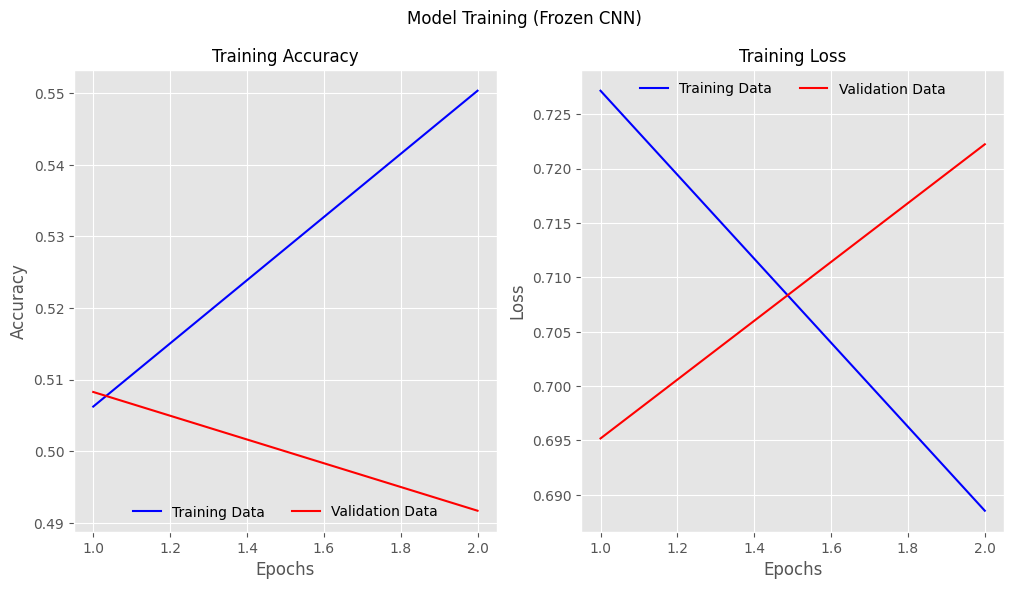

In [12]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [13]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/vgg19_model_01.weights.h5", overwrite=True) 

In [14]:
model_01.load_weights("model_weights/vgg19_model_01.weights.h5")
val_eval_01 = model_01.evaluate(valid_generator)
test_eval_01 = model_01.evaluate(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.4682 - loss: 0.7246


C:\python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.5241 - loss: 0.7038


In [15]:
print(f'Validation Loss: {val_eval_01[0]}')
print(f'Validation Acc: {val_eval_01[1]}')
print(f'Testing Loss: {test_eval_01[0]}')
print(f'Testing Acc: {test_eval_01[1]}')

Validation Loss: 0.7276120781898499
Validation Acc: 0.4751381278038025
Testing Loss: 0.7095134854316711
Testing Acc: 0.519336998462677


In [16]:
# Unfreezing and fine tuning
# retraining the last two conv Layers
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [37]:
# remove block 5_conv3 and block5_conv4
x=base_model.output
flat = Flatten()(x)

layer_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(layer_1)
layer_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(layer_2)

model_02 = Model(base_model.inputs, output)
# load the weights into model 2
model_02.load_weights('model_weights/vgg19_model_01.weights.h5')

# unfreezing block 5_conv3 and block5_conv4
set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        layer.trainable =True
    else:
        layer.trainable=False
print(model_02.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [38]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [39]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 20, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5450 - loss: 0.7069
Epoch 1: val_loss did not improve from 0.64952
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 14s/step - accuracy: 0.5440 - loss: 0.7087 - val_accuracy: 0.5580 - val_loss: 0.6804 - learning_rate: 1.0000e-04
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5010 - loss: 0.7044
Epoch 2: val_loss did not improve from 0.64952
10/10 ━━━━━━━━━━━━━━━━━━━━ 131s 14s/step - accuracy: 0.5038 - loss: 0.7042 - val_accuracy: 0.5304 - val_loss: 0.6903 - learning_rate: 1.0000e-04
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5773 - loss: 0.6796
Epoch 3: val_loss did not improve from 0.64952
10/10 ━━━━━━━━━━━━━━━━━━━━ 136s 14s/step - accuracy: 0.5796 - loss: 0.6785 - val_accuracy: 0.5912 - val_loss: 0.6564 - learning_rate: 1.0000e-04
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6132 - loss: 0.6597
Epoch 4: val_loss improved from 0.64952 to 0.64730, saving model to model.keras
10/10 ━━━━━━

C:\python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 5: val_loss did not improve from 0.64730
10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 9s/step - accuracy: 0.5794 - loss: 0.7109 - val_accuracy: 0.5912 - val_loss: 0.6496 - learning_rate: 1.0000e-04
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6206 - loss: 0.6477
Epoch 6: val_loss improved from 0.64730 to 0.59758, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 136s 14s/step - accuracy: 0.6237 - loss: 0.6449 - val_accuracy: 0.7182 - val_loss: 0.5976 - learning_rate: 1.0000e-04
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6108 - loss: 0.6565
Epoch 7: val_loss did not improve from 0.59758
10/10 ━━━━━━━━━━━━━━━━━━━━ 140s 15s/step - accuracy: 0.6104 - loss: 0.6570 - val_accuracy: 0.6575 - val_loss: 0.6214 - learning_rate: 1.0000e-04
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6779 - loss: 0.5959
Epoch 8: val_loss did not improve from 0.59758
10/10 ━━━━━━━━━━━━━━━━━━━━ 138s 14s/step - accuracy: 0.6768 - loss: 0.5963 - val_accuracy: 0.651

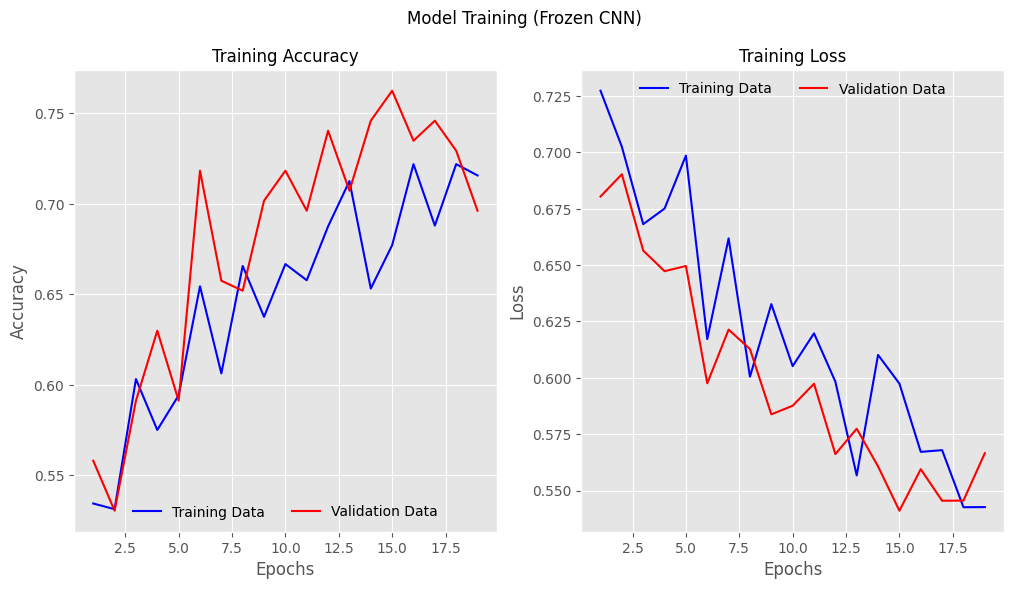

In [48]:
# Assuming you just want to plot the final values directly without moving average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)

# Plotting training accuracy
ax1.plot(epochs_list, history_02.history['accuracy'], color='b', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

# Plotting training loss
ax2.plot(epochs_list, history_02.history['loss'], color='b', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()


In [42]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg19_model_02.weights.h5", overwrite=True)

In [43]:
model_02.load_weights("model_weights/vgg19_model_02.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.7604 - loss: 0.5363
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.7211 - loss: 0.5649


In [45]:
# Unfreezing the entire network
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])
model_03.summary()

C:\python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs = 5, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.7607 - loss: 0.5233 

C:\python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_145']. Received: the structure of inputs=*
  warnings.warn(



Epoch 1: val_loss did not improve from 0.54105
10/10 ━━━━━━━━━━━━━━━━━━━━ 299s 30s/step - accuracy: 0.7595 - loss: 0.5238 - val_accuracy: 0.7403 - val_loss: 0.5464 - learning_rate: 1.0000e-04
Epoch 2/5


C:\python310\lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.7704 - loss: 0.5177 
Epoch 2: val_loss improved from 0.54105 to 0.51093, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 378s 39s/step - accuracy: 0.7706 - loss: 0.5192 - val_accuracy: 0.7624 - val_loss: 0.5109 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.6965 - loss: 0.5962 
Epoch 3: val_loss improved from 0.51093 to 0.48456, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 399s 39s/step - accuracy: 0.6984 - loss: 0.5924 - val_accuracy: 0.7735 - val_loss: 0.4846 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.7351 - loss: 0.5268 
Epoch 4: val_loss did not improve from 0.48456
10/10 ━━━━━━━━━━━━━━━━━━━━ 389s 39s/step - accuracy: 0.7334 - loss: 0.5288 - val_accuracy: 0.6851 - val_loss: 0.5512 - learning_rate: 1.0000e-04
Epoch 5/5
 6/10 ━━━━━━━━━━━━━━━━━━━━ 2:09 32s/step - accuracy: 0.7273 - loss: 0.5421

C:\python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 5: val_loss improved from 0.48456 to 0.47416, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 254s 25s/step - accuracy: 0.7322 - loss: 0.5347 - val_accuracy: 0.8011 - val_loss: 0.4742 - learning_rate: 1.0000e-04


In [50]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg_unfrozen.weights.h5", overwrite=True)
model_03.load_weights("model_weights/vgg_unfrozen.weights.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

C:\python310\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 40 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step - accuracy: 0.7117 - loss: 0.5425
6/6 ━━━━━━━━━━━━━━━━━━━━ 51s 8s/step - accuracy: 0.7204 - loss: 0.5609
